In [ ]:
# initial-model-brainstorming.ipynb
#
# Bryan Daniels
# 2023/8/25
#

Goal: build a computational model of decision-making that matches with the Laplace
transform picture of Howard et al. 2018 and is implemented using believable neural
dynamics.  In our current picture, to do this we need:

   - Units connected in a 1-D topology with marginally stable activity patterns
     that consist of an "edge" at any location along the line
   - With incoming evidence, the edge should move, ideally scaling as $1/t$

We initially had two ideas for implementing this:
   
   1) Ising-type model with ferromagnetic interactions and the two boundary conditions fixed in opposite directions
   2) "Continuous attractor network" appropriately modified to produce an edge instead of a Gaussian bump.  (And/or modified to produce a pitchfork bifurcation as a function of an external input)

# Ising formulation

In [88]:
# import ising_decisions as ising # we'll just use coniii directly instead
import coniii
import simpleNeuralModel
import numpy as np
import scipy.stats
import tqdm
import matplotlib.pyplot as plt
from toolbox import defaultFigure
defaultFigure.setDefaultParams()

In [2]:
def J_matrix_to_J_flat(Jmat):
    """
    Flatten interaction matrix in a way consistent with coniii
    """
    Jflat = [ Jmat[i,j] for i,j in np.transpose(np.triu_indices_from(Jmat,k=1)) ]
    return Jflat

In [4]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

N = 20 # number of units
J = 10000. # constant interaction strength between neighbors
boundary_field = 1e9 # field setting boundary conditions

# make J interaction matrix and h fields
Jmat = J * np.diag(np.ones(N-1),k=1)  
hlist = np.zeros(N)
hlist[0] = boundary_field
hlist[-1] = -boundary_field

# `multipliers` here consists of N individual parameters followed by 
# N(N-1)/2 pairwise parameters (ordered as in np.triu_indices(N,k=1)) 
Jflat = J_matrix_to_J_flat(Jmat)
multipliers = np.append(hlist,Jflat)

In [5]:
n_samples = 1000
samples = coniii.samplers.sample_ising(multipliers,n_samples)

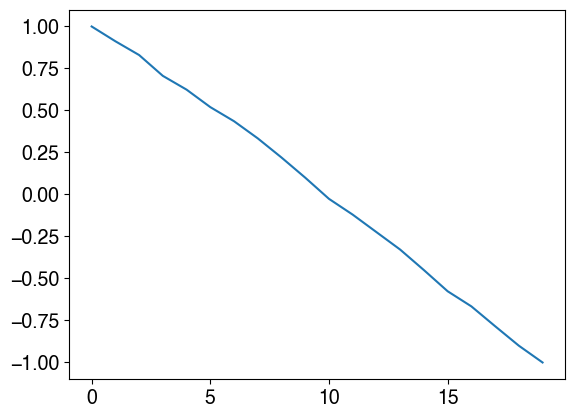

In [6]:
plt.plot(np.mean(samples,axis=0))

In [73]:
samples[0]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1, -1], dtype=int8)

In [74]:
domain_boundaries = np.diff(samples,axis=1)

In [75]:
domain_boundaries[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,
        0,  0], dtype=int8)

In [76]:
np.mean(np.abs(domain_boundaries))

0.10526315789473684

# continuous dynamics formulation

In [3]:
def gaussian_kernel_matrix(N,width,normed=True):
    """
    Interaction matrix with Gaussian kernel.
    
    N:       total number of units.  Returned interaction matrix will have shape (N,N)
    width:   width of the Gaussian measured in number of units
    """
    mat = [ scipy.stats.distributions.norm.pdf(range(N),loc=i,scale=width) for i in range(N) ]
    if normed:
        mat = [ row/np.sum(row) for row in mat ]
    return np.array(mat)

In [168]:
# set up 1-D line of units with nearest-neighbor interactions
# and fixed boundary conditions implemented by large fields at the ends

N = 50 # number of units
J = 2 # constant interaction strength between neighbors
boundary_input = 100. # field setting boundary conditions
noiseVar = .10 # strength of noise (variance added per unit time)
tFinal = 20

# make J interaction matrix 
# nearest-neighbors only
#Jmat = J * ( np.diag(np.ones(N-1),k=1) + np.diag(np.ones(N-1),k=-1) )
# gaussian kernel
kernel_width = 4 #2
Jmat = J * gaussian_kernel_matrix(N,kernel_width)
# set external inputs
inputExt = np.zeros(N)
num_inputs = 5 # number of fixed input nodes at each end
inputExt[0:num_inputs] = boundary_input
inputExt[-num_inputs:] = -boundary_input

Text(0, 0.5, 'Interaction kernel')

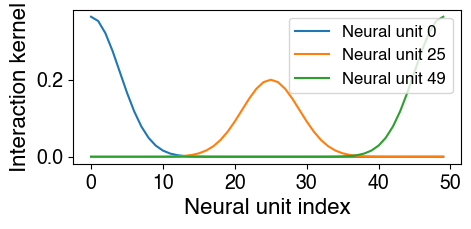

In [169]:
plt.figure(figsize=(5,2))
for i in [0,N/2,N-1]:
    plt.plot(Jmat[int(i)],label="Neural unit {}".format(int(i)))
plt.legend()
plt.xlabel('Neural unit index')
plt.ylabel('Interaction kernel')

In [157]:
states = simpleNeuralModel.simpleNeuralDynamics(Jmat,inputExt,noiseVar=noiseVar,tFinal=tFinal)
rates = np.tanh(states)

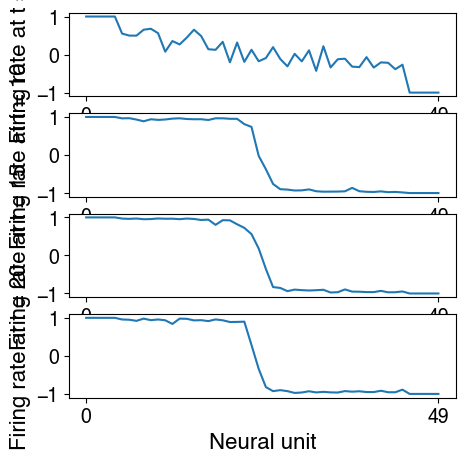

In [158]:
times = [1,10,15,20]
plt.figure(figsize=[5,5])
for i,time in enumerate(times):
    plt.subplot(len(times),1,i+1)
    plt.plot(rates.loc[time])
    plt.xlabel('Neural unit')
    plt.ylabel('Firing rate at t = {}'.format(time))
    plt.xticks(ticks=[0,N-1],labels=[0,N-1]);
    #plt.axis(ymin=-20,ymax=20)

In [9]:
fixed_points = simpleNeuralModel.findFixedPoints(Jmat,inputExt,useMeanField=False)

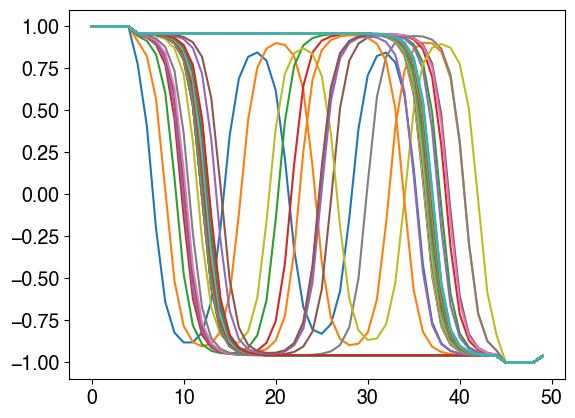

In [28]:
for fp in np.array(fixed_points):
    plt.plot(np.tanh(fp))
#plt.axis(ymin=-10,ymax=10)

In [159]:
# try stationary states ("fixed points") that look like an edge
# TO DO: plot desired location versus initial location
center_list = range(0,N,2)
fp_list = []
for center in center_list:
    width = 2
    initialGuessState = -(np.arange(0,N)-center)/width
    initialGuessRates = np.tanh(initialGuessState)
    fp = simpleNeuralModel.findFixedPoint(Jmat,initialGuessState,inputExt=inputExt)
    fp_list.append(fp)

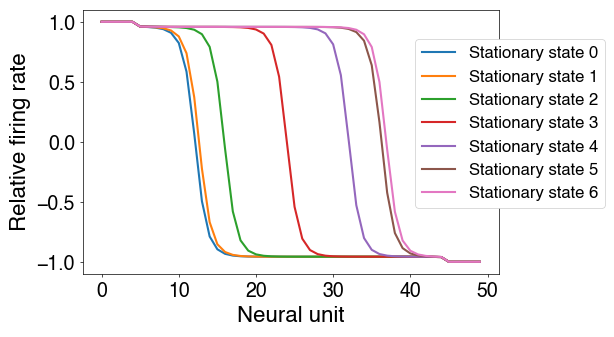

In [160]:
for i,fp in enumerate(fp_list[::4]):
    #plt.plot(initialGuessRates)
    plt.plot(np.tanh(fp),label='Stationary state {}'.format(i))
plt.xlabel('Neural unit')
plt.ylabel('Relative firing rate')
leg = plt.legend(loc=(0.8,0.25),framealpha=1)
defaultFigure.makePretty(leg)
plt.subplots_adjust(left=0.15,right=0.8,bottom=0.25,top=0.8)
plt.savefig('230829_edge_stationary_states.pdf')

In [170]:
# check that these attractors are stationary under the dynamics
rates_list,states_list = [],[]
tFinal = 50 #100 #20
seed = 12345

np.random.seed(seed)
for fp in tqdm.tqdm(fp_list):
    states = simpleNeuralModel.simpleNeuralDynamics(Jmat,
                                                    inputExt,
                                                    noiseVar=noiseVar,
                                                    tFinal=tFinal,
                                                    initialState=fp)
    rates = np.tanh(states)
    rates_list.append(rates)
    states_list.append(states)

100%|███████████████████████████████████████████| 25/25 [00:25<00:00,  1.04s/it]


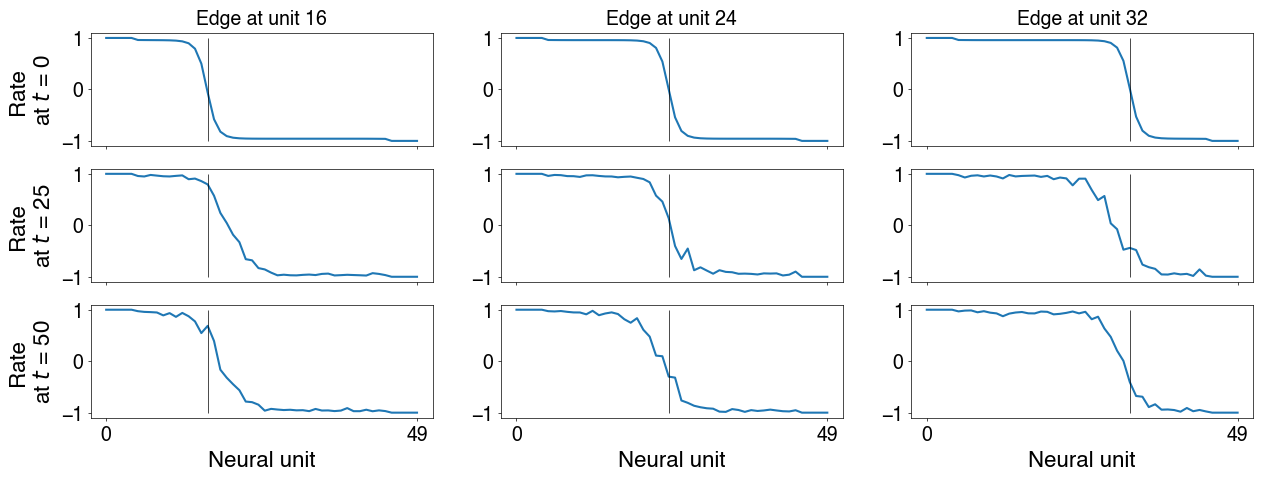

In [171]:
times = [0,int(tFinal/2),tFinal]
center_index_list = [8,12,16]
plt.figure(figsize=[15,5])
for j,center_index in enumerate(center_index_list):
    desired_center = center_list[center_index]
    for i,time in enumerate(times):
        plt.subplot(len(times),len(center_index_list),(j+1)+i*len(center_index_list))

        # plot rates as a function of neural unit
        plt.plot(rates_list[center_index].loc[time])
        # plot vertical line at desired center (where relative rate should be zero)
        plt.vlines(desired_center,-1,1,color='k',lw=0.5)

        if i==len(times)-1: # include labels on bottom plot
            plt.xticks(ticks=[0,N-1],labels=[0,N-1])
            plt.xlabel('Neural unit')
        else: # just ticks on other plots
            plt.xticks(ticks=[0,N-1],labels=[])
            
        if i==0: # include title on top plot
            plt.title("Edge at unit {}".format(desired_center))
        
        if j==0: # include labels on left plots
            plt.ylabel('Rate \nat $t$ = {}'.format(time))

        #plt.axis(ymin=-20,ymax=20)
        defaultFigure.makePretty()
#plt.savefig('230829_edge_noisy_dynamics.pdf')

(-2.45, 51.45, -5.0, 5.0)

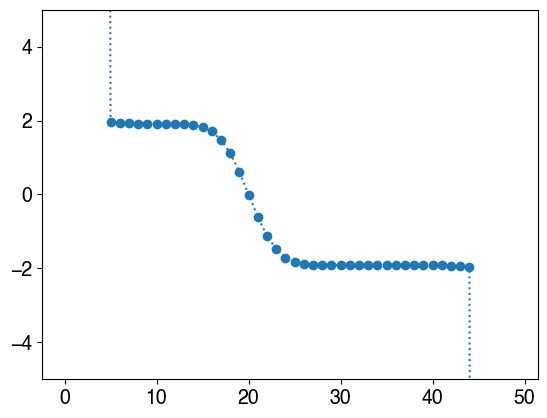

In [165]:
plt.plot(fp_list[10],'o:')
plt.axis(ymin=-5,ymax=5)